In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Model fitting and Pavlovian biases. Pavlovian-instrumental interactions

## Part 1

Download the dataset .csv from Slack. It contains the data of 10 subjects (see column "ID" for the subject identifier), performing a go/no-go task, each for 600 trials. The column "cue" informs you about the presented trial type (see the "cue mapping" variable in our template). The column "pressed" contains the response of the participant (0 is no-go, 1 is go) and "outcome" contains whether a reward was delivered (1), nothing was delivered (0), a punishment was given (-1).

Recreate figure 2E of the paper "Go and no-go learning in reward and punishment: Interactions between affect and effect" with the data you have. Only the bar plots are important here, no need for error bars or significance tests.

In [6]:
data = pd.read_csv("gen_data.csv")

# Go+ = Go to win
# Go- = go to avoid losing
# NoGo+ = don't go to win
# NoGo- = don't go to avoid losing
cue_mapping = { 1: "Go+", 2: "Go-", 3: "NoGo+", 4: "NoGo-" }

data["CueFactor"] = [cue_mapping.get(cue) for cue in data.cue]
data["CueFactor"] = data["CueFactor"].astype("category")

In [7]:
# Determine if each trial is correct or not
data["Correct"] = False
for i, trial in data.iterrows():
    if trial.CueFactor == "Go+" or trial.CueFactor == "Go-":
        data.loc[i, "Correct"] = trial.pressed == 1

    if trial.CueFactor == "NoGo+" or trial.CueFactor == "NoGo-":
        data.loc[i, "Correct"] = trial.pressed != 1

# Compute the average of correct values for each cue
cue_means = data.groupby(["ID", "CueFactor"], observed = False)["Correct"].mean()

In [8]:
means = []
cues = []
for cue in data.CueFactor.unique():
    cue_data = cue_means.xs(cue, level = "CueFactor")
    means.append(np.mean(cue_data))
    cues.append(cue)

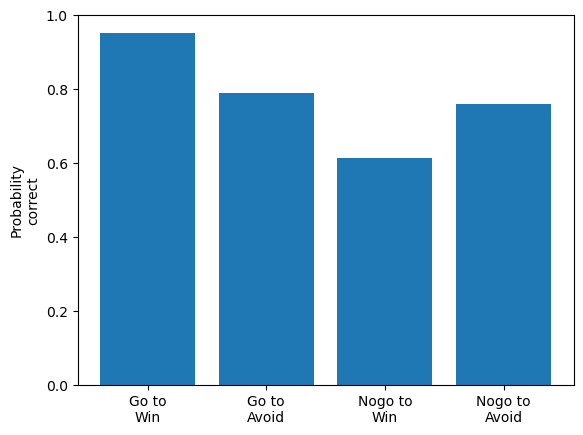

In [9]:
plt.bar(cues, means)
plt.ylabel("Probability\ncorrect")
plt.ylim(0, 1)
plt.xticks(
    ticks = cues,
    labels = [
        "Go to\nWin",
        "Go to\nAvoid",
        "Nogo to\nWin",
        "Nogo to\nAvoid"
    ]
)
plt.show()

## Part 2

Program the log likelihood functions of the models 1 to 7 (including) presented in "Disentangling the Roles of Approach, Activation and Valence in Instrumental and Pavlovian Responding" (see Table 2 of that paper for the model numbering and relevant parameters). The paper uses these parameters:

- learning rate $\epsilon$
- feedback sensitivity $\beta$
- the general feedback sensitivity $\beta$ can be replaced by separate reward and punishment sensitivities $\rho$ (we don’t include a sensitivity for omission)
- there can be different learning rates $\epsilon$ for reward, feedback omission, and punishment (the paper doesn't make use of omissions, so they use only two learning rates, you will need three)
- there can be a general bias to approach $bias_{app}$, and a general bias to withhold responding $bias_{wth}$

### General model

$s^{\mathcal{I}}_t$ - the instrumental stimulus, presented at trial $t$ (one out of four: Go+, Go-, NoGo+, and NoGo-).

$a_t$ - the action (choice) at trial $t$. The action can be one of four types: in the withdrawal block, (1) go withdrawal and (2) nogo withdrawal, and in the approach block, (3) go approach and (4) nogo approach.

$r_t$ - the reinforcement obtained, $r_t \in \{-1, 0, 1\}$ where $-1$ marks a punishment, $0$ marks no reinforcement (feedback omission), and $-1$ marks a reward.

The probability of action $a_t$ in the presence of stimulus $s^{\mathcal{I}}_t$ is a standard probabilistic function:

$$
p(a_t | $s^{\mathcal{I}}_t$) = \frac{exp(\mathcal{W}^{\mathcal{I}} ($s^{\mathcal{I}}_t$, a_t))}{\sum_{a'} exp(\mathcal{W}^{\mathcal{I}} ($s^{\mathcal{I}}_t$, a'))}
$$

Here, $\mathcal{W}^{\mathcal{I}}$ is the instrumental weight of action $a_t$:

$$
\mathcal{W}^{\mathcal{I}}(s^{\mathcal{I}}_t, a_t) = \mathcal{Q}(s^{\mathcal{I}}_t, a_t) + b(a_t)
$$

The variable $b(a_t)$ can take on value $bias_{wth}$ for withhold actions, or $bias_{app}$ for approach actions.

The Q-values are updated according to a Rescorla-Wagner-like rule with a fixed learning rate $\epsilon$. The immediate, intrinsic, value of the reinforcements may have a different meaning for different subjects. To measure this effect, two further parameters are added: $\rho_{rew}$ for the reward sensitivity and $\rho_{pun}$ for the punishment sensitivity. Update equation for the expectations is thus:

$$
\mathcal{Q}_{t+1}(s^{\mathcal{I}}_t, a_t) = \mathcal{Q}_{t}(s^{\mathcal{I}}_t, a_t) + \epsilon (\mathcal{R}_t - \mathcal{Q}_{t}(s^{\mathcal{I}}_t, a_t))
$$

$$
\mathcal{R}_t =\begin{cases}
      \rho_{rew} & \text{ if }\ r_t > 0 \\
      \rho_{pun} & \text{ if }\ r_t < 0 \\
    \end{cases}
$$


In [130]:
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp)

In [113]:
def rescorla_wagner(q_val, epsilon_rew, epsilon_pun, epsilon_omi, reward):
    """
    Recalculates Q-value based on received reward and provided learning rates.
    :param q_val: current Q-value
    :param epsilon_rew: learning rate (reward)
    :param epsilon_pun: learning rate (punishment)
    :param epsilon_omi: learning rate (omission)
    :param reward: reward
    :return: updated Q-value
    """
    if reward > 0:
        return q_val + epsilon_rew * (reward - q_val)

    if reward < 0:
        return q_val + epsilon_pun * (reward - q_val)

    return q_val + epsilon_omi * (reward - q_val)

In [45]:
def reward(a_t, r_t, params):
    rho_rew, rho_pun = params
    if r_t > 0: return rho_rew
    if r_t < 0: return rho_pun
    return 0

In [46]:
def bias(a, bias_app, bias_wth):
    """
    Calculates response bias
    
    :param a: action taken (1 - approach, 0 - withhold)
    :param bias_app: approach action bias
    :param bias_wth: withhold action bias
    :return: response bias
    """
    return bias_app if a == 1 else bias_wth

In [47]:
def weight(q_val, a, bias_app, bias_wth):
    return q_val + bias(a, bias_app = bias_app, bias_wth = bias_wth)

In [147]:
def log_likelihood(cues, actions, rewards, epsilon_rew, epsilon_pun, epsilon_omi, bias_app, bias_wth, reward_fun, reward_fun_params):
    """ Calculate log-likelihood
    
    :param cues: presented stimuli
    :param actions: performed actions
    :param rewards: gained rewards
    :param epsilon_rew: learning rate (reward)
    :param epsilon_pun: learning rate (punishment)
    :param epsilon_omi: learning rate (omission)
    :param bias_app: approach bias
    :param bias_wth: withhold bias
    :param reward_fun: function to calculate the reward
    :param reward_fun_params: parameters to pass to the reward function
    :return: 
    """
    n_stimuli = len(set(cues))
    n_actions = len(set(actions))

    q_vals = np.zeros((n_stimuli, n_actions))
    w_vals = np.zeros((n_stimuli, n_actions))

    log_likelihood = 0

    for t, a_t in enumerate(actions):
        s_t = cues[t] - 1
        r_t = reward_fun(a_t, rewards[t], reward_fun_params)

        probs = softmax(w_vals[s_t] * [0, 1])

        log_likelihood += np.sum(np.log(probs))

        # Update the Q-values using Rescorla-Wagner
        q_vals[s_t, a_t] = rescorla_wagner(
            q_val = q_vals[s_t, a_t],
            epsilon_rew = epsilon_rew,
            epsilon_pun = epsilon_pun,
            epsilon_omi = epsilon_omi,
            reward = r_t
        )

        # Update weights based on the Q-values and response bias
        w_vals[s_t, a_t] = weight(q_vals[s_t, a_t], a = a_t, bias_app = bias_app, bias_wth = bias_wth)
        w_vals[s_t, 1 - a_t] = weight(q_vals[s_t, 1 - a_t], a = 1 - a_t, bias_app = bias_app, bias_wth = bias_wth)

    return log_likelihood

### Model 1

Model 1 assumes that $-\rho_{pun} = \rho_{rew} = \beta$ and that $bias_{wth} = bias_{app} = 0$.

In [148]:
def model1(cues, actions, rewards, epsilon, beta):
    """
    Log-likelihood for model 1
    :param cues: 
    :param actions: 
    :param rewards: 
    :param epsilon: learning rate
    :param beta: feedback sensitivity
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon,
        epsilon_pun = epsilon,
        epsilon_omi = epsilon,
        bias_app = 0,
        bias_wth = 0,
        reward_fun = reward,
        reward_fun_params = (beta, -beta)
    )

### Model 2

Model 2 includes separate reward and punishment sensitivities $\rho_{rew}$ and $\rho_{pun}$ with no action bias $bias_{wth} = bias_{app} = 0$.

In [74]:
def model2(cues, actions, rewards, epsilon, rho_rew, rho_pun):
    """
    Log-likelihood for model 2
    :param cues: 
    :param actions: 
    :param rewards: 
    :param epsilon: learning rate
    :param rho_rew: feedback sensitivity (reward)
    :param rho_pun: feedback sensitivity (punishment)
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon,
        epsilon_pun = epsilon,
        epsilon_omi = epsilon,
        bias_app = 0,
        bias_wth = 0,
        reward_fun = reward,
        reward_fun_params = (rho_rew, rho_pun)
    )

### Model 3

Model 3 again assumes $-\rho_{pun} = \rho_{rew} = \beta$, and that $bias_{wth} = bias_{app} = 0$, but allows for two separate learning rates, i.e. $\epsilon$ is replaced by $\epsilon_{rew}$ on trials where $r_t = 1$, by $\epsilon_{pun}$ on trials where $r_t = -1$, and by $\epsilon_{omi}$ on trials where $r_t = 0$.

In [75]:
def model3(cues, actions, rewards, epsilon_rew, epsilon_pun, epsilon_omi, beta):
    """
    Log-likelihood for model 3
    :param cues: 
    :param actions: 
    :param rewards: 
    :param epsilon_rew: learning rate (reward)
    :param epsilon_pun: learning rate (punishment)
    :param epsilon_omi: learning rate (omission)
    :param beta: feedback sensitivity
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon_rew,
        epsilon_pun = epsilon_pun,
        epsilon_omi = epsilon_omi,
        bias_app = 0,
        bias_wth = 0,
        reward_fun = reward,
        reward_fun_params = (beta, -beta)
    )

### Model 4

Model 4 assumes a common learning rate $\epsilon$ and $-\rho_{pun} = \rho_{rew} = \beta$, but includes action biases for withdrawal actions $bias_{wth}$ and approach actions $bias_{app}$.

In [76]:
def model4(cues, actions, rewards, epsilon, beta, bias_app, bias_wth):
    """
    Log-likelihood for model 4
    :param cues: presented stimuli
    :param actions: performed actions
    :param rewards: gained rewards
    :param epsilon: learning rate
    :param beta: feedback sensitivity
    :param bias_app: approach bias
    :param bias_wth: withhold bias
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon,
        epsilon_pun = epsilon,
        epsilon_omi = epsilon,
        bias_app = bias_app,
        bias_wth = bias_wth,
        reward_fun = reward,
        reward_fun_params = (beta, -beta)
    )

### Model 5

Model 5 assumes a common learning rate $\epsilon$ with reward and punishment sensitivities $\rho_{rew}$ and $\rho_{pun}$, and includes action biases for withdrawal actions $bias_{wth}$ and approach actions $bias_{app}$.

In [77]:
def model5(cues, actions, rewards, epsilon, rho_rew, rho_pun, bias_app, bias_wth):
    """
    Log-likelihood for model 5
    :param cues: presented stimuli
    :param actions: performed actions
    :param rewards: gained rewards
    :param epsilon: learning rate
    :param rho_rew: feedback sensitivity (reward)
    :param rho_pun: feedback sensitivity (punishment)
    :param bias_app: approach bias
    :param bias_wth: withhold bias
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon,
        epsilon_pun = epsilon,
        epsilon_omi = epsilon,
        bias_app = bias_app,
        bias_wth = bias_wth,
        reward_fun = reward,
        reward_fun_params = (rho_rew, rho_pun)
    )

### Model 6

Model 6 allows for separate reward and punishment sensitivities for the approach and withhold actions: $\rho_{rew}^{app}$, $\rho_{rew}^{wth}$,  $\rho_{pun}^{app}$, and $\rho_{pun}^{wth}$.

In [78]:
def reward_2(a_t, r_t, params):
    rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth = params
    if a_t == 1 and r_t > 0: return rho_rew_app
    if a_t == 0 and r_t > 0: return rho_rew_wth

    if a_t == 1 and r_t < 0: return rho_pun_app
    if a_t == 0 and r_t < 0: return rho_pun_wth

    return 0

In [79]:
def model6(cues, actions, rewards, epsilon, rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth, bias_app, bias_wth):
    """
    Log-likelihood for model 6
    :param cues: presented stimuli
    :param actions: performed actions
    :param rewards: gained rewards
    :param epsilon: learning rate
    :param rho_rew_app: feedback sensitivity (reward for approach)
    :param rho_rew_wth: feedback sensitivity (reward for withhold)
    :param rho_pun_app: feedback sensitivity (punishment for approach)
    :param rho_pun_wth: feedback sensitivity (punishment for withhold)
    :param bias_app: approach bias
    :param bias_wth: withhold bias
    :return: 
    """

    return log_likelihood(
        cues = cues,
        actions = actions,
        rewards = rewards,
        epsilon_rew = epsilon,
        epsilon_pun = epsilon,
        epsilon_omi = epsilon,
        bias_app = bias_app,
        bias_wth = bias_wth,
        reward_fun = reward_2,
        reward_fun_params = (rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth)
    )

## Part 3

Create an additional model which takes into account Pavlovian biases. Use model 7 as a starting point for this. Add a parameter p to the model. To determine the action values to put into the softmax function for a given cue, take the Q-values, add the general bias to approach or withhold (as in equation 1 of the paper), and add p to the Q-value for approaching if the maximum Q-value for the current cue is positive, or add p to the Q-value for withholding if the maximal Q-value for the current cue is negative.

## Part 4

Optimize the models, by fitting all the parameters of each model to each individual subject, using the scipy minimize function. Pay attention to initialize the parameters to reasonable values and set sensible bounds for each parameter (since Q-values get turned into probabilities through a softmax, which uses an exponential function, you may have to limit some of the parameters to certain magnitudes, to prevent overflow errors). Given the number of models this can take some minutes, to save time you can e.g. only apply the logarithm at the end, rather than during every iteration of your for-loop.

### Model 1

w(s, a) = q(s, a) + b_wtf/app + p <- depending on the q value

In [149]:
epsilon_bounds = (0.00001, 0.99999)
beta_bounds = (0.1, 9.9999)
# biases can be negative!

In [150]:
def loss1(params, cues, actions, rewards):
    epsilon, beta = params
    return -model1(cues, actions, rewards, epsilon, beta)

In [151]:
min_loss = []

# for id in data.ID.unique():
subject_id = data.ID.unique()[0]
subject = data[ data.ID == subject_id ]

cues = subject.cue.tolist()
actions = subject.pressed.tolist()
rewards = subject.outcome.tolist()

model1(
    cues = cues,
    actions = actions,
    rewards = rewards,
    epsilon = 0.1,
    beta = 1
)

# res = minimize(
#     fun = loss1,
#     x0 = [0.1, 5],
#     bounds = [epsilon_bounds, beta_bounds],
#     args = (cues, actions, rewards),
#     method = "Nelder-Mead"
# )

# min_loss.append(res.fun)

-878.0106431244467

### Part 5

Sum up the optimized log-likelihoods across all subjects for each model. Use this and all other relevant values to compute the BIC score for each model (using e.g. the BIC equation of Wikipedia). What does this tell you about which model describes the data best?

In [22]:
def bic(k, n, l):
    """
    Calculate BIC criteria.
    :param k: number of parameters estimated by the model.
    :param n: sample size.
    :param l: maximized value of the likelihood function of the model
    :return: BIC
    """
    return k * np.log(n) - 2 * np.log(l)